<img src="imagen.png"  align="left" style="width: 270px;"/>

## Desenvolupament Big Data PQTM 19 

### Projecte II : Infraestructures distribuïdes per a Big Data

**Alumnos:** Nicolás D'Alessandro y Daniel Benitez García

## 00 - Enunciado

  - Una institución hospitalaria quiere implementar una solución de Big Data para obtener información valiosa sobre la tipología de enfermos que está tratando. Se propone implementar una solución Big Data para que sea posible crear acceder a los datos y realizar un  tratamiento de la información para obtener inisghts sobre los enfermos.  
  
  
  - Habrá que buscar orígenes de datos abiertos (Open Data) que contengan información en formato archivo y base de datos. Lo que se pretende es determinar si la contaminación del aire es un factor determinante para la generación de alguna enfermedad. En caso de serlo se procesará en tiempo real la contaminación y se determinará cuáles son las enfermedades que se pueden dar con más probabilidad.
 

## PARTE 1: Establecer si la contaminación del Aire es factor determinante en el origen de enfermedades.

### 00 - Definiciones

Para la realización de este proyecto utilizaremos dos metodos diferentes, por un lado aplicaremos <span style="font-family: Courier New; background-color: #D3D3D3; color: #000000; padding: 3px; ">ESTADISTICA CLASICA</span> a través de un test de hipótesis (para este caso "Test Chi Cuadrado - X2") y por otro lado utilizaremos <span style="font-family: Courier New; background-color: #ffcc5c; color: #000000; padding: 3px; ">ESTADISTICA MODERNA</span> a través de un modelo de ML que nos permita analizar la "feature importance" de la variable **contaminación del aire**, a fin de observar si la misma contribuye hacia la "predicción" de **Enfermedades**, lo que significará que esta variable aporta información estadística importante sobre nuestro target.

### 01 - Test estadístico

    
        
        
   - Escogeremos la prueba de **Chi Cuadrado** <span style="font-family: Courier New; background-color: #D3D3D3; color: #000000; padding: 3px; ">X2</span> para evaluar hipótesis acerca de la relación entre dos variables.  Hipótesis a probar : Correlaciónales -> <span style="font-family: Courier New; background-color: #D3D3D3; color: #000000; padding: 3px; ">H0</span> : no hay asociación  y  <span style="font-family: Courier New; background-color: #D3D3D3; color: #000000; padding: 3px; ">H1</span>   hay asociación. El análisis estadístico se aplicará a los indicadores para determinar si hay algún cambio a lo largo del tiempo y si los mismos son **estadísticamente significativos**.  
   

#### **PASO 1:** Proponer las Hipótesis

<span style="font-family: Courier New; background-color: #ffcc5c; color: #000000; padding: 3px; ">H0</span>: Las variables **Enfermedades** y **Contaminación del Aire** son independientes.  

<span style="font-family: Courier New; background-color: #f87900; color: #000000; padding: 3px; ">H1</span>: Las variables **Enfermedades** y **Contaminación del Aire** son dependientes, por lo tanto la contaminación del aire es un valor determinante en la generación de enfermedades.

<img src="aceptacion.png"  align="center" style="width: 600px;"/>

#### **PASO 2:** Especificar "$\alpha$"  (Nivel de Significancia)

<span style="font-family: Courier New; background-color: #82b74b; color: #000000; padding: 4px; ">$\alpha$</span> = 0,05 
  
  
Utilizaremos un nivel de significancia del 5% (p <0.05), lo que implica que la conclusión de significancia se realizará solo cuando no hay más de un 5% de probabilidad de que el cambio observado en el tiempo haya ocurrido al azar. 

#### a: Antes de comenzar importamos las librerias necesarias para realizar el trabajo

In [4]:
import os
import sys

spark_path = "/usr/lib/spark"

os.environ['SPARK_HOME'] = spark_path
os.environ['HADOOP_HOME'] = spark_path

sys.path.append(spark_path + "/bin")
sys.path.append(spark_path + "/python")
sys.path.append(spark_path + "/python/pyspark/")
sys.path.append(spark_path + "/python/lib")
sys.path.append(spark_path + "/python/lib/pyspark.zip")
sys.path.append(spark_path + "/python/lib/py4j-0.8.2.1-src.zip")

#Pyspark Imports
stdout = sys.stdout
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout = stdout
from pyspark.sql import HiveContext
import pyspark.sql.functions as F

hiveContext = HiveContext(sc)
from pyspark.sql import Row
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType

#from pyspark.mllib.clustering import KMeans, KMeansModel
#from numpy import array
#from math import sqrt

In [29]:
import pandas as pd
import numpy as np

from scipy.spatial.distance import cdist
from matplotlib import pyplot as plt


Hay que instalar panda en la máquiina de CDH por ello hay que instalar previamente anaconda

#### b: GENERACIÓN DEL DATASET PARA TEST DE HIPÓTESIS

    ### DATASET 01: HeathRiskCountryAirPollutionTabaccoDiseases

In [6]:
deathsByCountryFile=sc.textFile("HeathRiskCountryAirPollutionTabaccoDiseases.csv")
deathsByCountry=deathsByCountryFile.map(lambda line: line.replace("Tracheal, bronchus, and lung cancer", "Tracheal bronchus and lung cancer"))\
.map(lambda line:line.split(","))\
.filter(lambda fields:fields[3] in ("Slovenia","United States"))\
.filter(lambda fields:fields[11] not in ("Secondhand smoke","Tobacco","Smoking"))\
.map(lambda fields:((fields[3],fields[14]),(fields[15])))

In [7]:
schemaDeathsByCountry = hiveContext.inferSchema(deathsByCountry)\
.withColumnRenamed("_1","id").withColumnRenamed("_2","Value")
deathsByCountryData=schemaDeathsByCountry.select(F.col("id._1")\
.alias("Country"),F.col("id._2").alias("Year"),\
F.col("Value").alias("Value").cast("int"))\
.groupBy("Country","Year").sum("Value").orderBy("Country","Year")
deathsByCountryData=deathsByCountryData.withColumnRenamed(deathsByCountryData.columns[2],"Illness")
deathsByCountryData.show(5)

Country  Year Illness
Slovenia 1990 187    
Slovenia 1991 543    
Slovenia 1992 499    
Slovenia 1993 529    
Slovenia 1994 142    


    ### DATASET 02: PollutionEmmisionsManMadeByCountryAnualSeries

In [8]:
pollutionEmisionByCountryFile=sc.textFile("PollutionEmmisionsManMadeByCountryAnualSeries.csv")
pollutionEmisionByCountry=pollutionEmisionByCountryFile\
.map(lambda line: line.replace("Total emissions, Index 1990 = 100","Total emissions Index 1990 = 100"))\
.map(lambda line: line.replace("Total emissions per unit of GDP, Kg per 1000 USD","Total emissions per unit of GDP Kg per 1000 USD"))\
.map(lambda line: line.replace("Total emissions, Index 2000 = 100","Total emissions Index 2000 = 100"))\
.map(lambda line:line.replace("\"",""))\
.map(lambda line:line.split(","))\
.filter(lambda fields:fields[1] in ("Slovenia","United States"))\
.map(lambda fields:((fields[1],fields[6]),fields[14]))

In [9]:
schemaPollutionEmisionByCountry = hiveContext.inferSchema(pollutionEmisionByCountry)\
.withColumnRenamed("_1","id").withColumnRenamed("_2","Value")
pollutionEmisionByCountryData=schemaPollutionEmisionByCountry.select(F.col("id._1")\
.alias("Country"),F.col("id._2").alias("Year"),\
F.col("Value").alias("Value").cast("float"))\
.groupBy("Country","Year").max("Value").orderBy("Country","Year")
pollutionEmisionByCountryData=pollutionEmisionByCountryData.withColumnRenamed(pollutionEmisionByCountryData.columns[2],"Contamination" )
pollutionEmisionByCountryData.show(5)

Country  Year Contamination
Slovenia 1990 304.436      
Slovenia 1991 285.58       
Slovenia 1992 275.236      
Slovenia 1993 289.02       
Slovenia 1994 281.972      


In [10]:
joinTables=deathsByCountryData.join\
(pollutionEmisionByCountryData,(pollutionEmisionByCountryData.Country==deathsByCountryData.Country) & \
(pollutionEmisionByCountryData.Year==deathsByCountryData.Year))\
.select(deathsByCountryData.Country,deathsByCountryData.Year,\
       deathsByCountryData.Illness,pollutionEmisionByCountryData.Contamination).orderBy("Country","Year")
joinTables.show(5)

Country  Year Illness Contamination
Slovenia 1990 187     304.436      
Slovenia 1991 543     285.58       
Slovenia 1992 499     275.236      
Slovenia 1993 529     289.02       
Slovenia 1994 142     281.972      


    ### Graficamos las dimensiones contaminación y enfermedades para observar si hay clusters 

Preparamos datos en Hive para zeppelin

In [11]:
joinTables.registerTempTable("tbl_tmp")
hiveContext.sql("drop table if exists contamination_illness")
hiveContext.sql("Create table contamination_illness as select * from tbl_tmp")

DataFrame[]

<img src="Hive.png"  align="center" style="width: 900px;"/>

<img src="Zeppelin.png"  align="center" style="width: 1000px;"/>

    ### Seleccionamos el mejor numeo de K utilizando "elbow method" con 'Distortion' y 'Inertia'

In [12]:
df=joinTables.select(F.col("illness"),F.col("Contamination"))

In [19]:
# ML models
#from sklearn.linear_model import LinearRegression
#from sklearn.linear_model import LassoCV,Lasso
#from sklearn.metrics import mean_squared_error
#from catboost import Pool, CatBoostRegressor
from sklearn.cluster import KMeans
import sklearn as sk


In [30]:
distortions = [] 
inertias = [] 
k_range = range(1,15) 
 
df_kmeans=df.select("*").toPandas()

for k in k_range:  
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_kmeans)     
      
    distortions.append(sum(np.min(cdist(df_kmeans, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / df_kmeans.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
    
plt.style.use('ggplot')

fig0 = plt.figure(figsize=(8, 8))
ax0 = fig0.add_subplot(211)

ax0.plot(k_range, distortions, 'bx-') 
ax0.set_title('Select best K using The Elbow Method with Distortions') 
ax0.set_xlabel('Values of K') 
ax0.set_ylabel('Distortion') 
plt.show() 

fig1 = plt.figure(figsize=(8, 8))
ax1 = fig1.add_subplot(211)

ax1.plot(k_range, inertias, 'bx-') 
ax1.set_title('Select best K using The Elbow Method with Inertia') 
ax1.set_xlabel('Values of K') 
ax1.set_ylabel('Inertia') 
plt.show() 

    ### Realizamos el k-means con el número óptimo de clusters elegidos

In [33]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(df)
Centers = kmeans.cluster_centers_
predictions = kmeans.predict(df)

ValueError: setting an array element with a sequence.

    ### Anexamos la columna con el cluster al dataframe original

In [11]:
df = pd.concat([df.reset_index(), pd.DataFrame({'Group': predictions})], axis=1)

    ### Graficamos los clusters

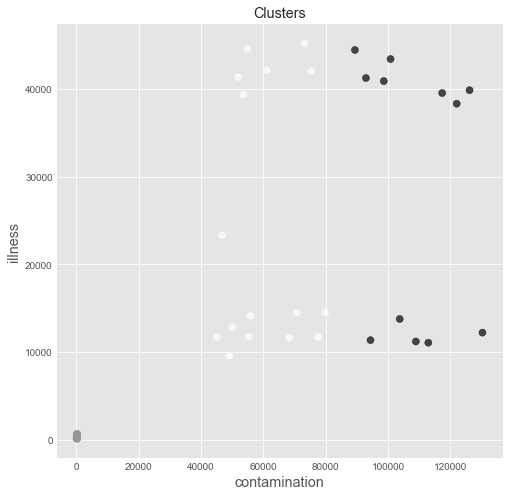

In [12]:
plt.style.use('ggplot')

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

ax.set_title('Clusters')
ax.set_xlabel('contamination', fontsize =  'x-large')
ax.set_ylabel('illness', fontsize =  'x-large')

ax.scatter(df['contamination'], df['illness'], c = df['Group'], s=50, alpha = 0.7)

#### **PASO 3**: Elaboramos nuesta tabla de contingencia

<img src="contingencia.png"  align="center" style="width: 600px;"/>

In [13]:
df_test = df_test.groupby('country').agg({'contamination':'max', 'illness':'sum'})
df_test.reset_index()
df_test

,contamination,illness
country,,
Slovenia,304.436,10206
United States,130278.132,738131


In [354]:
contingencia=joinTables.groupBy('Country').agg({'Contamination':'max', 'Illness':'sum'})
contingencia.show()

Country       MAX(Contamination#3630) SUM(Illness#3655L)
Slovenia      130278.13               19316             
United States 130278.13               1474812           


#### **PASO 4:** Especificar "***V***"  (Grados de libertad)

<img src="chi2.gif"  align="left" style="width: 15px;"/> = K-1-m = 2 - 1 = **1**

*K = número de clasificaciones en el problema.  
*m = número de parámetros estimados a partir de los datos muestrales para obtener los valores esperados.

#### **PASO 5:** Calcular valores crítico y de prueba

<img src="chi1.gif"  align="center" style="width: 400px;"/>

In [82]:
#utilizamos la librería sikit learn para obetener dichos valores. PENDIENTE FINALIZAR

#### **PASO 5:** Decisión y Conclusión  

<span style="font-family: Courier New; background-color: #ffcc5c; color: #000000; padding: 3px; ">DECISIÓN</span>: Se rechaza la hipótesis nula y se acepta la hipótesis alternativa  
  
<span style="font-family: Courier New; background-color: #f80000; color: #000000; padding: 3px; ">CONCLUSIÓN</span>: Luego de realizar nuestro test de hipótesis para comprobar la relación entre las variables propuestas con la evidencia muestral seleccionada, podemos concluir que la exposición a la contaminación del aire es factor determinante en el origen de enfermedades.

## 02 - Construcción de un Modelo de Machine Learning

#### a: GENERACIÓN DEL DATASET PARA MODELO DE ML

    ### DATASET 01: HeathRiskCountryAirPollutionTabaccoDiseases

In [15]:
ml2 = pd.read_csv('HEALTH_STAT_07122019003230420.csv')
ml2 = ml2[ml2['Variable'] == 'Total population at birth']

In [16]:
life_expect_ml = ml2.groupby(['Country', 'Year']).agg({'Value':'mean'})
life_expect_ml = life_expect_ml.reset_index()
life_expect_ml = life_expect_ml.rename(columns={'Country': 'country', 'Year':'year','Value':'life_expect_ml'})
life_expect_ml.head()

,country,year,life_expect_ml
0,Australia,1990,77.0
1,Australia,1991,77.4
2,Australia,1992,77.5
3,Australia,1993,78.0
4,Australia,1994,78.0


    ### DATASET 02: HistorialPopulation1990_2017PerCountry

In [17]:
ml3 = pd.read_csv('HistorialPopulation1990_2017PerCountry.csv')

In [18]:
population_ml = ml3.groupby(['Country', 'Time']).agg({'Value':'sum'})
population_ml = population_ml.reset_index()
population_ml = population_ml.rename(columns={'Country': 'country', 'Time':'year', 'Value':'population_ml'})
population_ml.head()

,country,year,population_ml
0,Argentina,1990,2.490197e+08
1,Argentina,1991,2.525995e+08
2,Argentina,1992,2.561734e+08
3,Argentina,1993,2.597202e+08
4,Argentina,1994,2.632184e+08


    ### DATASET 03: PollutionEmmisionsManMadeByCountryAnualSeries

In [19]:
ml4 = pd.read_csv('PollutionEmmisionsManMadeByCountryAnualSeries.csv')

/Users/nicolasdalessandro/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [20]:
indices_ml = ml4.groupby(['Country', 'Year']).agg({'Value':'max'})
indices_ml = indices_ml.reset_index()
indices_ml = indices_ml.rename(columns={'Country': 'country', 'Year':'year', 'Value':'contamination_ml'})
indices_ml.head()

,country,year,contamination_ml
0,Australia,1990,5728.460
1,Australia,1991,5747.308
2,Australia,1992,5896.593
3,Australia,1993,6120.709
4,Australia,1994,6262.916


    ### DATASET 04: PollutionEmmisionsManMadeByCountryAnualSeriesa

In [21]:
ml5 = pd.read_csv('AnualGDPPerCountry.csv')

In [22]:
PBI_ml = ml5.groupby(['Country', 'Year']).agg({'Value':'max'})
PBI_ml =  PBI_ml.reset_index()
PBI_ml = PBI_ml.rename(columns={'Country': 'country', 'Year':'year', 'Value':'PBI_ml'})
PBI_ml.head()

,country,year,PBI_ml
0,Argentina,2004,4.003708e+06
1,Argentina,2005,4.358102e+06
2,Argentina,2006,4.708805e+06
3,Argentina,2007,5.132958e+06
4,Argentina,2008,5.341214e+06


    ### DATASET 05: FOREST_06122019234144255.csv

In [23]:
ml6 = pd.read_csv('FOREST_06122019234144255.csv')

In [24]:
forest_ml = ml6.groupby(['Country', 'Year']).agg({'Value':'sum'})
forest_ml =  forest_ml.reset_index()
forest_ml = forest_ml.rename(columns={'Country': 'country', 'Year':'year', 'Value':'forest_ml'})
forest_ml.head()

,country,year,forest_ml
0,Australia,1990,34859.000
1,Australia,1995,39120.000
2,Australia,2000,48814.727
3,Australia,2001,24474.000
4,Australia,2002,24296.000


    ### DATASET 06: AV_AN_WAGE_07122019001021425.csv

In [25]:
ml7 = pd.read_csv('AV_AN_WAGE_07122019001021425.csv')

In [26]:
wage_ml = ml7.groupby(['Country', 'Time']).agg({'Value':'mean'})
wage_ml =  wage_ml.reset_index()
wage_ml = wage_ml.rename(columns={'Country': 'country', 'Time':'year', 
                                              'Value':'wage_ml'})
wage_ml.head()

,country,year,wage_ml
0,Australia,1990,44887.842550
1,Australia,1991,45081.484579
2,Australia,1992,46206.461459
3,Australia,1993,46882.868496
4,Australia,1994,47396.764410


    ### Finalmente generamos nuestro dataset para el MODELO de ML

In [27]:
df_ml = indices_ml.set_index(['country', 'year']).join(population_ml.set_index(['country', 'year']))
df_ml = df_ml.reset_index()
df_ml = df_ml.set_index(['country', 'year']).join(PBI_ml.set_index(['country', 'year']))
df_ml = df_ml.reset_index()
df_ml = df_ml.set_index(['country', 'year']).join(forest_ml.set_index(['country', 'year']))
df_ml = df_ml.reset_index()
df_ml = df_ml.set_index(['country', 'year']).join(wage_ml.set_index(['country', 'year']))
df_ml = df_ml.reset_index()
df_ml = df_ml.set_index(['country', 'year']).join(life_expect_ml.set_index(['country', 'year']))
df_ml = df_ml.reset_index()

    ### Usamos el metodo de interpolación lineal para completar valores faltantes

In [28]:
df_ml['forest_ml'] = df_ml['forest_ml'].interpolate(method='linear')
df_ml['life_expect_ml'] = df_ml['life_expect_ml'].interpolate(method='linear')
df_ml['wage_ml'] = df_ml['wage_ml'].interpolate(method='linear')

In [29]:
df_ml = df_ml.dropna()

In [30]:
df_ml.shape

(1005, 8)

In [31]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1005 entries, 0 to 1045
Data columns (total 8 columns):
country             1005 non-null object
year                1005 non-null int64
contamination_ml    1005 non-null float64
population_ml       1005 non-null float64
PBI_ml              1005 non-null float64
forest_ml           1005 non-null float64
wage_ml             1005 non-null float64
life_expect_ml      1005 non-null float64
dtypes: float64(6), int64(1), object(1)
memory usage: 70.7+ KB


    ### Visualizamos los datos y graficamos las correlaciones

In [32]:
df_ml.drop(columns=['country', 'year']).corr()

,contamination_ml,population_ml,PBI_ml,forest_ml,wage_ml,life_expect_ml
contamination_ml,1.000000,0.870362,-0.040218,0.445432,-0.056822,-0.158431
population_ml,0.870362,1.000000,-0.044232,0.220930,-0.028788,-0.197451
PBI_ml,-0.040218,-0.044232,1.000000,-0.047876,0.034426,-0.217871
forest_ml,0.445432,0.220930,-0.047876,1.000000,-0.042868,0.033855
wage_ml,-0.056822,-0.028788,0.034426,-0.042868,1.000000,0.122934
life_expect_ml,-0.158431,-0.197451,-0.217871,0.033855,0.122934,1.000000


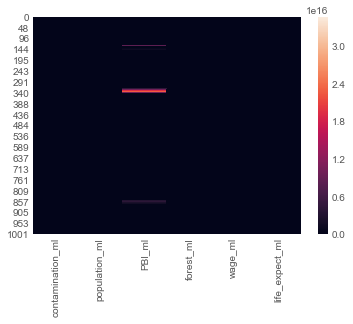

In [33]:
import seaborn as sns
ax = sns.heatmap(df_ml.drop(columns=['country', 'year']))

    ### Separamos el dataset en Train y Test definiendo "illness" como nuestra variable "target"

In [34]:
df_ml.head()

,country,year,contamination_ml,population_ml,PBI_ml,forest_ml,wage_ml,life_expect_ml
0,Australia,1990,5728.460,1.335825e+08,2.149930e+06,34859.0,44887.842550,77.0
1,Australia,1991,5747.308,1.353209e+08,1.287432e+06,35711.2,45081.484579,77.4
2,Australia,1992,5896.593,1.368764e+08,1.545503e+06,36563.4,46206.461459,77.5
3,Australia,1993,6120.709,1.381406e+08,2.169026e+06,37415.6,46882.868496,78.0
4,Australia,1994,6262.916,1.395673e+08,1.658637e+06,38267.8,47396.764410,78.0


    ### Tratamiento de variables categóricas: One hot encoding
    Utilizaremos one-hot-encoding para tratar las variables categóricas, a fin de que pueda entenderlas nuestro fúturo modelo

In [35]:
#definimos una función para aplicarl el OHE
def one_hot_simple(data,columns_encoding,erase=False):
    '''
    Basic method and non optimized for One Hot Encoding, 
    >>> data: [dataframe] with different features.
    >>> columns: [list] of columns to encode.
    >>> erase: [Boolean] for keeping or not the original columns (by default False)
    ---------------------------------------------------------
    <<< Returns the [dataframe] with or without the original columns (erase)
    '''
    for col in columns_encoding:
        variables = data[col].unique()
        for v in variables:
            data[col + str(v)] = [1 if row == v else 0 for row in data[col].values]
    if erase:
        return data.drop(columns=columns_encoding)
    return data

In [36]:
help(one_hot_simple)

Help on function one_hot_simple in module __main__:

one_hot_simple(data, columns_encoding, erase=False)
    Basic method and non optimized for One Hot Encoding, 
    >>> data: [dataframe] with different features.
    >>> columns: [list] of columns to encode.
    >>> erase: [Boolean] for keeping or not the original columns (by default False)
    ---------------------------------------------------------
    <<< Returns the [dataframe] with or without the original columns (erase)



In [37]:
#aplicamos la función creada
df_ml = one_hot_simple(df_ml,['country'],erase = False)

    ### Target Encoding:


Utilizaremos catboost encoding:
      
   - Fuentes: (https://contrib.scikit-learn.org/categorical-encoding/catboost.html)  
   - Paper citation: [CatBoost: unbiased boosting with categorical features](https://arxiv.org/abs/1706.09516)

**Nota**: Esto no esta hecho en modo "best practice" de desarrollo. Para eso habría que usar un Pipeline. A modo de ejercicio lo realizaremos de esta manera.

In [38]:
cbe = ce.cat_boost.CatBoostEncoder()

In [39]:
cbe.fit(df_ml,df_ml.life_expect_ml)

CatBoostEncoder(a=1, cols=['country'], drop_invariant=False,
                handle_missing='value', handle_unknown='value',
                random_state=None, return_df=True, sigma=None, verbose=0)

In [40]:
df_ml = cbe.transform(df_ml)

    ### Train test Split

Dado que este es un conjunto de datos denominado "serie temporal", el tratamiento de los datos en el tiempo es de suma importancia, significando que realmente no se puede usar datos futuros para predecir eventos pasados. Por lo tanto, la división por Asunto no tiene mucho sentido aquí, ya que estaríamos entrenando al modelo con observaciones futuras pero probándolo en las pasadas (por ejemplo, entrenar en el período {1 3 4 5 6} y probar en el período {2}) .

El flujo debe seguir un patrón, con nuevos datos que se ingieren en el conjunto de entrenamiento y se utilizan para predecir la variable objetivo en el futuro. A la luz de esto, usaremos solo la división por tiempo.

In [41]:
df_ml.head()

,country,year,contamination_ml,population_ml,PBI_ml,forest_ml,wage_ml,life_expect_ml,countryAustralia,countryAustria,...,countryPortugal,countryRussia,countrySlovak Republic,countrySlovenia,countrySpain,countrySweden,countrySwitzerland,countryTurkey,countryUnited Kingdom,countryUnited States
0,80.080277,1990,5728.460,1.335825e+08,2.149930e+06,34859.0,44887.842550,77.0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,80.080277,1991,5747.308,1.353209e+08,1.287432e+06,35711.2,45081.484579,77.4,1,0,...,0,0,0,0,0,0,0,0,0,0
2,80.080277,1992,5896.593,1.368764e+08,1.545503e+06,36563.4,46206.461459,77.5,1,0,...,0,0,0,0,0,0,0,0,0,0
3,80.080277,1993,6120.709,1.381406e+08,2.169026e+06,37415.6,46882.868496,78.0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,80.080277,1994,6262.916,1.395673e+08,1.658637e+06,38267.8,47396.764410,78.0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
df_ml = df_ml.sort_values(by=['year'])

In [43]:
train = df_ml.drop(columns=['life_expect_ml', 'year'])
target = df_ml[['life_expect_ml']]
tscv = sk.model_selection.TimeSeriesSplit(n_splits=6)
for train_index, test_index in tscv.split(df_ml):
        print("TRAIN:", len(train_index), "TEST:", len(test_index),"SUM:",len(train_index)+len(test_index))
        X_train, X_test = train.iloc[train_index], train.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]

TRAIN: 147 TEST: 143 SUM: 290
TRAIN: 290 TEST: 143 SUM: 433
TRAIN: 433 TEST: 143 SUM: 576
TRAIN: 576 TEST: 143 SUM: 719
TRAIN: 719 TEST: 143 SUM: 862
TRAIN: 862 TEST: 143 SUM: 1005


In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    df_ml.drop(columns=['life_expect_ml', 'country', 'year']), 
    df_ml['life_expect_ml'], test_size=0.75, random_state=42)

#### c: Ajustaremos diferentes modelos para encontrar el más optimo

    ### 01 - Linear Regression 

In [45]:
#entrenamos el modelo en nuestro dataset
reg_model = LinearRegression(normalize=True)
reg_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [46]:
#observamos el score en el dataset train para comprobar que no haya "overfiting"
reg_model.score(X_train, y_train)

0.7707093706323696

In [47]:
#al ser un modelo de regresión, observaremos también el RMSE ya que en estos casos suele ser más intuitivo
mean_squared_error(reg_model.predict(X_train),y_train).round(2)

3.01

In [48]:
#observamos las mismas métricas sobre el Test para medir la eficiencia de nuestro modelo

In [49]:
reg_model.score(X_test, y_test)

-7.640531562433718e+19

In [50]:
mean_squared_error(reg_model.predict(X_test),y_test).round(2)

1.0703929439417686e+21

In [51]:
#extraemos los coeficientes
reg_model.coef_

array([ 1.39756781e-04,  9.78732597e-09, -1.94988204e-16,  1.13977567e-05,
        6.36791614e-07,  1.78737667e+12,  1.78737667e+12,  1.78737667e+12,
        1.78737667e+12,  1.78737667e+12,  1.15213015e+12,  1.78737667e+12,
        1.78737667e+12,  1.78737667e+12,  1.78737667e+12,  1.78737667e+12,
        1.78737667e+12,  1.78737667e+12,  1.78737667e+12,  1.78737667e+12,
        1.78737667e+12,  1.78737667e+12,  1.78737667e+12,  1.78737667e+12,
        1.78737667e+12,  1.78737667e+12,  1.78737667e+12,  1.78737667e+12,
        1.78737667e+12,  1.78737667e+12,  1.78737667e+12,  1.78737667e+12,
        1.78737667e+12,  1.78737667e+12,  1.78737667e+12,  1.78737667e+12,
        1.78737667e+12,  1.78737667e+12,  1.78737667e+12,  1.78737667e+12,
        1.78737667e+12,  1.78737667e+12,  1.78737667e+12,  1.78737667e+12])

In [52]:
#creamos una función para observar la "feature importance" en nuestros modelos
def plot_feature_importance(columnas,model_features,columns_ploted=10,model_name='Catboost',savefig = False):
    '''
    This function receives a set of columns feeded to a model, and the importance of each of feature.
    Returns a graphical visualization.
    
    Call it fot catboost pipe example:
    plot_feature_importance(pipe_best_estimator[:-1].transform(X_tr).columns,
    pipe_best_estimator.named_steps['cb'].get_feature_importance(),20)
    
    Call it for lasso pipe example:
    plot_feature_importance(pipe_best_estimator[:-1].transform(X_tr).columns,
    np.array(pipe_best_estimator.named_steps['clf'].coef_.squeeze()),20)

    '''

    feature_importance = pd.Series(index = columnas, data = np.abs(model_features))
    n_selected_features = (feature_importance>0).sum()
    print('{0:d} features, reduction of {1:2.2f}%'.format(n_selected_features,
                                                          (1-n_selected_features/len(feature_importance))*100))
    plt.figure()
    feature_importance.sort_values().tail(columns_ploted).plot(kind = 'bar', figsize = (18,6))
    plt.title('Feature Importance for {}'.format(model_name))
    if savefig != False:
        plt.savefig(savefig)
    plt.show()


44 features, reduction of 0.00%


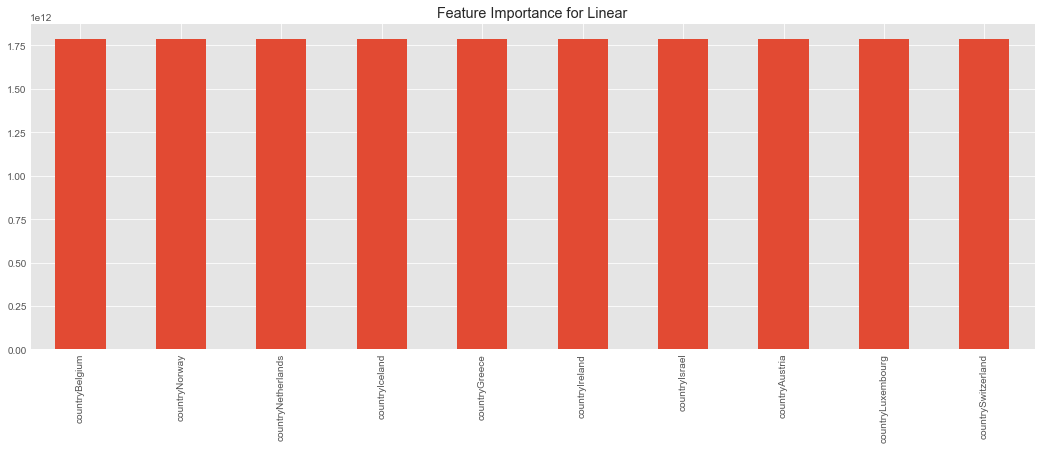

In [53]:
#ejecutamos la función creada para graficar
plot_feature_importance(X_train.columns,reg_model.coef_.squeeze(),
                        columns_ploted=10, model_name='Linear')

 <span style="font-family: Courier New; background-color: #ffcc5c; color: #000000; padding: 3px; ">OBSERVACIÓN DEL MODELO:</span> Podemos observar que el modelo elegido (regresión lineal) no ajusta bien, los resultados obtenidos no son óptimos para un análisis, lo que nos obliga a buscar una nueva opción eligiendo otro modelo

    ### 02 - Lasso (least absolute shrinkage and selection operator)

In [54]:
#repetimos el mismo procedimiento, cambiando de módelo

In [55]:
reg_lasso = Lasso(random_state=0,alpha=1).fit(X_train, y_train)

In [56]:
reg_lasso.score(X_train, y_train)

0.13187233497358897

In [57]:
mean_squared_error(reg_lasso.predict(X_train),y_train).round(2)

11.38

In [58]:
reg_lasso.score(X_test, y_test)

0.0931657334289675

In [59]:
mean_squared_error(reg_lasso.predict(X_test),y_test).round(2)

12.7

5 features, reduction of 88.64%


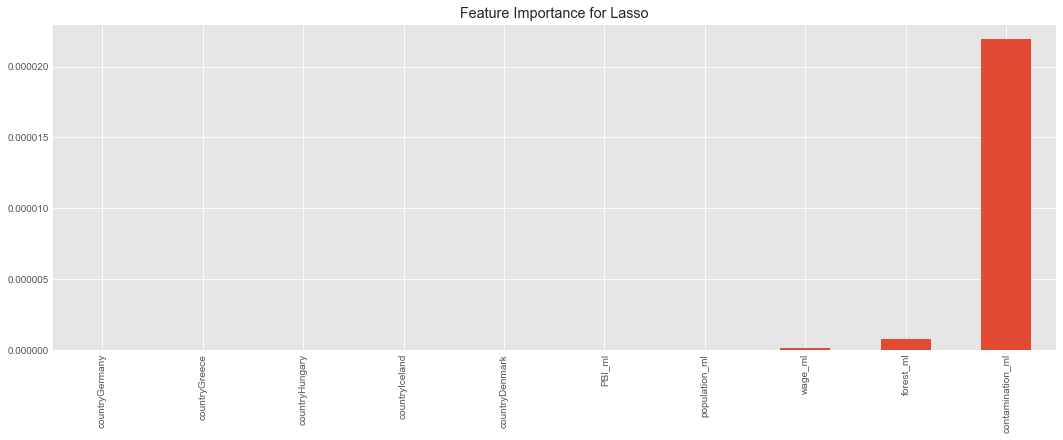

In [60]:
plot_feature_importance(X_train.columns,reg_lasso.coef_.squeeze(),model_name='Lasso')

<span style="font-family: Courier New; background-color: #ffcc5c; color: #000000; padding: 3px; ">OBSERVACIÓN DEL MODELO:</span> Este modelo, si bien ajusta mejor que el anterior, sigue siendo malo para la predicción de nuestro target. Sin embargo podemos observar que la variable country ya no es tan importante, lo que significa que las resto de variables empiezan a ser más importantes que el país. Podemos observar también que la variable "contaminación del aire" comienza a tomar protagonismo.

    ### 03 - xgb: Catbost

In [61]:
#repetimos el mismo procedimiento, cambiando de módelo

In [62]:
cb = CatBoostRegressor()

In [63]:
cb.fit(X_train,y_train)

0:	learn: 3.5794851	total: 52.5ms	remaining: 52.5s
1:	learn: 3.5378887	total: 53.5ms	remaining: 26.7s
2:	learn: 3.4960510	total: 54.3ms	remaining: 18.1s
3:	learn: 3.4594268	total: 55.4ms	remaining: 13.8s
4:	learn: 3.4173627	total: 56.1ms	remaining: 11.2s
5:	learn: 3.3812965	total: 56.9ms	remaining: 9.43s
6:	learn: 3.3487129	total: 57.7ms	remaining: 8.19s
7:	learn: 3.3115236	total: 58.5ms	remaining: 7.25s
8:	learn: 3.2888368	total: 59.3ms	remaining: 6.53s
9:	learn: 3.2603793	total: 60.1ms	remaining: 5.95s
10:	learn: 3.2365027	total: 61.7ms	remaining: 5.55s
11:	learn: 3.2050253	total: 63.1ms	remaining: 5.19s
12:	learn: 3.1751127	total: 63.9ms	remaining: 4.85s
13:	learn: 3.1436508	total: 64.7ms	remaining: 4.56s
14:	learn: 3.1165108	total: 65.6ms	remaining: 4.3s
15:	learn: 3.0892930	total: 66.3ms	remaining: 4.08s
16:	learn: 3.0632438	total: 67.1ms	remaining: 3.88s
17:	learn: 3.0288783	total: 68ms	remaining: 3.71s
18:	learn: 3.0018228	total: 68.9ms	remaining: 3.56s
19:	learn: 2.9670142	tota

In [64]:
cb.score(X_train,y_train)

0.9933524627555478

In [65]:
mean_squared_error(cb.predict(X_train),y_train).round(2)

0.09

In [66]:
cb.score(X_test,y_test)

0.8987676419077852

In [67]:
mean_squared_error(cb.predict(X_test),y_test).round(2)

1.42

43 features, reduction of 2.27%


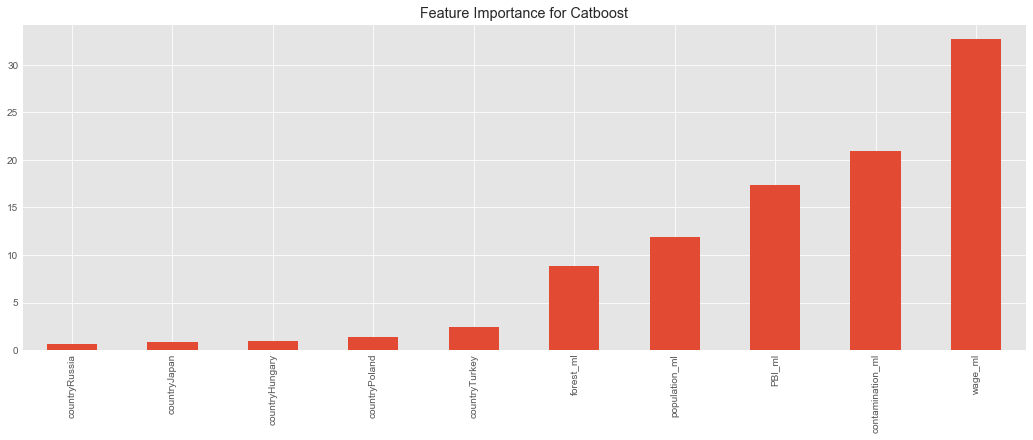

In [68]:
plot_feature_importance(X_train.columns,cb.get_feature_importance())

<span style="font-family: Courier New; background-color: #f80000; color: #000000; padding: 3px; ">CONCLUSIÓN</span>: Llegando al modelo que mejor ajusta, podemos observar que la variable "contaminación del aire" a pesar de no ser la más importante, es una variable clave en la esperanza de vida de la población mundial. Por tanto, podemos concluir que **la posibilidad de medir la "contaminacion del aire" en tiempo real, será un aporte de valor hacía la sociedad.**

_____________

## PARTE 2: Monitoreo en tiempo real de la **Contaminación del Aire**

### 01 - Introducción: Air Polution

   - El aire puro es una mezcla de varios gases como nitrógeno, oxígeno, argón, dióxido de carbono y pequeñas cantidades de otros gases en una proporción fija. Si la composición del aire se altera por algún medio, lo denominamos **contaminación del aire**, pudiendo provocar efectos en la salud humana, el medio ambiente y otras formas de vida (comprobaciíon objetivo de este análisis).  
   

   - Según la Ley del Aire (prevención y control de la contaminación) de 1981, **"la contaminación del aire es la presencia de cualquier sustancia sólida, líquida o gaseosa en la atmósfera, en concentraciones que serán perjudiciales para los seres humanos u otras criaturas vivientes tales como plantas animales y elemnetos del medio ambiente".**  
   
   
   - La contaminación del aire se ha convertido en un grave problema y muchos de los países del mundo como Pakistán, Irán, India, Emiratos Árabes Unidos y China, entre otros, están formulando estrategias para enfrentarlo. Hay una serie de factores responsables de la composición alterada del aire ambiente que se pueden clasificar de diversas formas, aunque principalmente como **causas naturales y causas antropogénicas (artificiales).**

### 02 - Clasificación de los "Air Pollutants"

Aunque existen diversos metodos de clasificación de los contaminantes del aire, intentaremos cubrirlas con el siguiente gráfico:

<img src="Airp.png"  align="center" style="width: 700px;"/>

#### 02a - Let's "deep dive" en la clasificación por tamaño:

<img src="Size.jpg"  align="center" style="width: 700px;"/>

#### 02b - ¿Porqué definir la fuente?

Para mejorar el sistema de gestión de la calidad del aire, es importante conocer la fuente de contaminación y su contribución cuantitativa a la calidad del "aire ambiente". Esto puede hacerse a través del estudio de distribución de la fuente, pudiendo hacerce de dos maneras:

 - (i) Un enfoque **"top-down"** que comienza con el monitoreo de la contaminación.  
 
 
 - (ii) Un enfoque **"bottom-up"** comenzando con los datos de la actividad (como el consumo de combustible). 
 
El estudio de distribución de la fuente se basa en rastrear las fuentes a través del modelado de receptores y ayuda a identificar las mismas así como el grado de su aporte.

### 03 - National Ambient Air Quality Standards (NAAQS)

Según la "Environmental Protection Agency" de EE. UU. (EPA), los **criteria pollutants** son los contaminantes del aire en partículas, oxidantes fotoquímicos y ozono a nivel del suelo, monóxido de carbono, óxidos de azufre, óxidos de nitrógeno y plomo. Estos contaminantes son responsables de causar graves peligros para la salud y peligros ambientales tales como como smog, lluvia ácida, etc. Dichos contaminantes se denominan **criteria pollutants** según la "Ley de Aire Limpio de 1963".    
   
   - Las fuentes y los efectos de los contaminantes criterio se muestran en la siguiente Tabla:

<img src="Criteria1.jpg"  align="center" style="width: 550px;"/>

   - La EPA de EE. UU. establece **"estándares nacionales de calidad del aire"** basados parametros para la salud humana y/o el medio ambiente (caracterizaciones de información científica). Veamos el NAAQ 2009 en la siguiente tabla:

<img src="NAAQ.jpg"  align="center" style="width: 600px;"/>

### 04 - AQI (Air Quality Index) / ICA (Índice de calidad del Aire)

El **AQI/ICA** es un índice para la notificación de la calidad del aire a diario. Indica el grado de pureza o contaminación atmosférica y los efectos para la salud conexos que le podrían preocupar.   
El **AQI/ICA** gira en torno a los efectos en la salud que usted puede sufrir en unas cuantas horas o días tras respirar aire contaminado.   
La EPA calcula el **AQI/ICA** para cinco contaminantes atmosféricos principales reglamentados por la Ley del aire puro: ozono a nivel del suelo, contaminación por partículas, monóxido de carbono, dióxido de azufre y dióxido de nitrógeno. 

#### 04a - Definiciones

   - **AQI (english) / ICA (español)**: Índice de calidad del aire.  

   - **VL: Valor límite**: Es un nivel fijado basándose en conocimientos científicos, con el fin de evitar, prevenir o reducir los efectos nocivos para la salud humana, para el medio ambiente en su conjunto y demás bienes de cualquier naturaleza que debe alcanzarse en un periodo determinado y no superarse una vez alcanzado.  
   
   - **Índice global**: Se corresponderá con el mayor de los índices parciales obtenidos para cada contaminante.  

   - **Índice parcial diario**: Es el índice obtenido para cada contaminante, asociando el valor 100 con la concentración que representa el valor límite, calculado con las concentraciones diarias u octohorarias de cada contaminante, en función de cómo esté expresado su valor límite, y con la peor de las concentraciones horarias del día en cuestión.  

   - **Índice parcial horario**: Es el índice obtenido para cada contaminante, asociando el valor límite con la concentración que representa el valor límite horario de cada contaminante, obtenido teniendo en cuenta la más elevada de las concentraciones horarias de cada uno de los contaminantes.

#### 04b - ¿Cómo funciona el AQI? - Rango Cuantitativo

El valor del índice estará comprendido entre 0 y >150 de modo que cuanto mayor sea el índice, peor será la calidad del aire.
El criterio utilizado para asignar valores de concentración a los valores del índice, son los valores fijados en la legislación.  
Así, el valor del índice 0 corresponderá a una concentración nula de contaminante, y el valor 100 estará asociado al valor límite fijado por las directivas para cada uno de los contaminantes legislados.  
El valor del índice para cualquier otro valor de concentración, se obtendrá por **interpolación lineal**, por ser este la más sencilla y la más fácil de interpretar por el ciudadano.

<span style="font-family: Courier New; background-color: #D3D3D3; color: #000000; padding: 3px; ">Como ejemplo, si el **Valor Límite** fijado para para la concentración de SO2 es de **125 µg/m3**  la relación entre el Indice **I** y la Concentración **X** para el SO2 es (no variará): **I**= 0,8 **X** (0,8 porque la pendiente de la recta es 100/125. valor límite del Indice/valor límite de concentración).</span>

#### 04c - Interpretación del ICA / AQI - Rango cualitativo

El objeto del AQI es ayudar a comprender el significado de la calidad del aire local para su salud.  
A fin de facilitar su interpretación, el AQI se divide en seis categorías:

<img src="AQI.gif"  align="center" style="width: 600px;"/>

Cada categoría se corresponde con un nivel diferente de preocupación para la salud. Los seis niveles de preocupación para la salud y su significado son:

   - <span style="font-family: Courier New; background-color: #82b74b; color: #000000; padding: 3px; ">BUENO</span>: El AQI oscila entre 0 y 50. La calidad del aire se considera satisfactoria y la contaminación atmosférica presenta un riesgo escaso o nulo.
   - <span style="font-family: Courier New; background-color: #ffcc5c; color: #000000; padding: 3px; ">MODERADO</span>: El AQI oscila entre 51 y 100. La calidad del aire es aceptable pero para algunos contaminantes podría existir una preocupación moderada para la salud de un grupo muy pequeño de personas. Por ejemplo, las personas que son excepcionalmente sensibles al ozono pueden padecer síntomas respiratorios.
   - <span style="font-family: Courier New; background-color: #f87900; color: #000000; padding: 3px; ">INSALUBRE PARA GRUPOS SENSIBLES</span>: El AQI oscila entre 101 y 150. Si bien las personas en general no van a sufrir en esta gama del AQI, las personas con enfermedades pulmonares, los adultos mayores y los niños son más susceptibles a la exposición al ozono, mientras que las personas con cardiopatías y enfermedades pulmonares, los adultos mayores y los niños son más susceptibles a la presencia de partículas en el aire.
   - <span style="font-family: Courier New; background-color: #f80000; color: #000000; padding: 3px; ">INSALUBRE</span>: El AQI oscila entre 151 y 200. Todos pueden comenzar a padecer efectos adversos para la salud y los miembros de los grupos sensibles pueden padecer efectos más graves.
   - <span style="font-family: Courier New; background-color: #af85a7; color: #000000; padding: 3px; ">MUY INSALUBRE</span>: El AQI oscila entre 201 y 300. Esto desencadenaría una alerta sanitaria que implica que todos pueden padecer efectos más graves para la salud..
   - <span style="font-family: Courier New; background-color: #98736a; color: #000000; padding: 3px; ">PELIGROSO</span>: El AQI es superior a 300. Esto desencadenaría una advertencia sanitaria de condiciones de emergencia. Son mayores las probabilidades de que toda la población esté afectada.

**PASO 1:** Importamos un dataset ejemplo con las mediciones de los 5 pollutants

In [69]:
df = pd.read_csv('Air_Quality_Terrassa.csv')

    #### limpiamos un poco nuestro dataset

In [70]:
df = df.drop([973,974], axis=0)
df.columns = ['fecha','date', 'year','month', 
              'day', 'so2', 'no','no2','o3','co','pm10','dades_pendent_veri']
df = df.drop(['date'], axis=1)

In [71]:
df['no']=pd.to_numeric(df['no'], errors ='coerce')
df['so2']=pd.to_numeric(df['so2'], errors ='coerce')
df['no2']=pd.to_numeric(df['no2'], errors ='coerce')
df['o3']=pd.to_numeric(df['o3'], errors ='coerce')
df['co']=pd.to_numeric(df['co'], errors ='coerce')
df['pm10']=pd.to_numeric(df['pm10'], errors ='coerce')

In [72]:
df = df.fillna(0)
#df['fecha'] = pd.to_datetime(df['fecha'])
df.drop(columns= 'dades_pendent_veri', inplace=True)

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 973 entries, 0 to 972
Data columns (total 10 columns):
fecha    973 non-null object
year     973 non-null int64
month    973 non-null int64
day      973 non-null int64
so2      973 non-null float64
no       973 non-null float64
no2      973 non-null float64
o3       973 non-null float64
co       973 non-null float64
pm10     973 non-null float64
dtypes: float64(6), int64(3), object(1)
memory usage: 83.6+ KB


In [74]:
df.head()

,fecha,year,month,day,so2,no,no2,o3,co,pm10
0,01/01/2017,2017,1,1,1.0,16.0,32.0,21.0,0.0,18.0
1,02/01/2017,2017,1,2,1.0,24.0,40.0,21.0,0.0,24.0
2,03/01/2017,2017,1,3,2.0,60.0,47.0,12.0,0.0,38.0
3,04/01/2017,2017,1,4,1.0,22.0,40.0,21.0,0.0,25.0
4,05/01/2017,2017,1,5,2.0,42.0,52.0,19.0,0.0,30.0


**PASO 2:** Importamos un dataset ejemplo con las mediciones de los 5 pollutants Generamos un ejemplo de como podrian ingresar las lecturas en tiempo real y nuestra formula calcularía con ellos el índice de contaminación del áire.

In [75]:
example = df.head(1)

In [79]:
def getAQI(data, vl = {'so2': 0.80, 'no2':0.4 , 'pm10': 2, 'o3': 0.83, 'co': 0.1, 'no':0.3}):
    '''
    This function returns the AQI based on the values of criteria pollutants given and
    it tresholds.
    >>> data: [dataframe] dataset with criteria pollutants values.
    >>> vl: [dic {}] dictionary with the multiplication factor for each pollutant.
    --------------------------------------------------------------
    <<< vl: [dic {}] dictionary with the date and the corresponding AQI.
    ''' 
    AQI = {}
    for i in data.index:
        line = data.loc[i]
        index = []
        counter = 4
        for j in line[4:9]:
            index.append(j * vl[data.columns[counter]])
            counter += 1
            for k in index:
                AQI[data['fecha'][i]] = max(index).round(2)
    return AQI       

In [80]:
help(getAQI)

Help on function getAQI in module __main__:

getAQI(data, vl={'so2': 0.8, 'no2': 0.4, 'pm10': 2, 'o3': 0.83, 'co': 0.1, 'no': 0.3})
    This function returns the AQI based on the values of criteria pollutants given and
    it tresholds.
    >>> data: [dataframe] dataset with criteria pollutants values.
    >>> vl: [dic {}] dictionary with the multiplication factor for each pollutant.
    --------------------------------------------------------------
    <<< vl: [dic {}] dictionary with the date and the corresponding AQI.



In [81]:
#aplicamos nuestra finción para obtener el resultado esperado
getAQI(example)

{'01/01/2017': 17.43}

______